# DQN project MVA 

Student : Matthieu Toulemont

**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import os
import keras
import numpy as np
import io
import base64
from IPython.display import HTML, Video
import skvideo.io
import cv2
import json
import matplotlib.pyplot as plt

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense, Flatten
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

/Users/Toulemont/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self,e,folder):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

> The function act returns the next state given a specific action and a given state. 


>$\epsilon$ is the probability of exploration. Without it the agent would act solely on the knowledge it has accumulated so far. Even though this can lead to good reward, the agent might miss the opportunity of gaining better rewards via action or states it has never seen. 


>If $\epsilon$ is close to 1, the agents never uses its knowledge and acts randomly. An intermediate valuee of $\epsilon$ enables the agent to keep exploring and to use its knowledge to gain better rewards. 


***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e,folder):
        if folder not in os.listdir():
            os.mkdir(folder)
        skvideo.io.vwrite(os.path.join(folder,str(e) + '.mp4'), self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=10 # set small when debugging
epochs_test=1 # set small when debugging

# display videos
def display_videos(name, prefix):
    video = io.open(os.path.join(prefix,name), 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

The array **board** represents the reward with : 
<ul>
    <li>**-1** for poison</li>
    <li>**0.5** for food</li>
    <li>**0** otherwise</li>
</ul>

Whereas **position** represents the location of the agent with : 

<ul>
    <li>**-1** for outside walls</li>
    <li>**0** Otherwise</li>
</ul>

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0,self.n_action, size = 1)[0]

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [22]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
    if prefix not in os.listdir():
        os.mkdir(prefix)
    for e in range(epochs):
        
        ##### FILL IN HERE
        state = env.reset()
        
        win, lose, terminated = 0,0, False
        
        while not terminated:
            action = agent.act(state, train=False)
            next_state, reward, terminated = env.act(action)
            state = next_state
            if reward <=0:
                lose = lose - reward
            else:
                win = win + reward
        # Save as a mp4
        env.draw(prefix+str(e), folder=prefix)
        # Update stats
        score = score + win-lose
        if e%10==0:
            print("Win/lose count {}/{}. Average score ({})"
                  .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [24]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,1,prefix='random')
HTML(display_videos('random0.mp4', 'random'))

Win/lose count 5.0/11.0. Average score (-6.0)
Final score: -6.0


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




**Answer **

Let $\pi$ be a policy : 

**i**
$$Q^{\pi}(s,a)=E[\sum_{t=0}^{\infty}\gamma^{t} r(S_{t},A_{t})|S_{0}=s, A_{0}=a, A_{t} = \pi(S_{t}), \forall t \ge 1]$$


$$Q^{\pi}(s,a)=r(s,a) + \gamma E[\sum_{t=1}^{\infty}\gamma^{t-1} r(S_{t},A_{t})|S_{0}=s, A_{0}=a, A_{t} = \pi(S_{t}), \forall t \ge 1]$$
Using the properties of the conditional expectation we have : 
$$Q^{\pi}(s,a)=r(s,a) + \gamma E_{(s',a')\sim p(.|s,a)}[E[\sum_{t=1}^{\infty}\gamma^{t-1} r(S_{t},A_{t})|S_{1}=s', A_{1}=a']|S_{0}=s, A_{0}=a, A_{t} = \pi(S_{t}), \forall t \ge 1]$$


$$Q^{\pi}(s,a)=r(s,a) + \gamma E_{(s',a')\sim p(.|s,a)}[Q^{\pi}(s',a')]$$

$$Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a) + \gamma Q^{\pi}(s',a')]$$

**ii**

Given the optimal policy $\pi^*$

$$Q^{*}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a) + \gamma Q^{*}(s',a')]$$

$$Q^{*}(s,a)=E_{(s')\sim p(.|s,a)}[r(s,a) + \gamma Q^{*}(s',\pi^{*}(s'))]$$

Then by definition of the optimal policy $Q^{*}(s',\pi^{*}(s')) = \max_{a'} Q^{*}(s',a')$ we have 

$$Q^{*}(s,a)=E_{(s')\sim p(.|s,a)}[r(s,a) + \gamma \max_{a'}Q^{*}(s',a')]$$


**iii**

We want our $Q$-function estimate to converge towards $Q^*$ which is unknown. However the equation above gives us it one-step estimate which we can use to learn $Q$. Therefore 

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}

is a plausible objective function. 


***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def random_access(self):
        return self.memory[np.random.randint(0, len(self.memory), size=1)[0]]

***
The pipeline we will use for training is given below:

In [10]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    scores = []
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e), folder=prefix)

        # Update stats
        score += win-lose
        
        scores.append(score/(1+e))
        

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    plt.plot(scores)
    plt.title("Average Scores")
    plt.show()

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [12]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(s.reshape([1, s.shape[0], s.shape[1], s.shape[2]]))
                                                                   [0,:])

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            s_, n_s_, a_, r_, game_over_  = self.memory.random_access()
            
            if game_over_:
                input_states[i] = s_
                target_q[i,a_] = r_
            else:
                ######## FILL IN
                input_states[i] = s_
                target_q[i,a_] = r_ + self.discount*max(self.model.predict(n_s_.reshape([1, s_.shape[0], s_.shape[1], s_.shape[2]])).ravel())
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -4, 4)

        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        
        ####### FILL IN
        model = Sequential()
        model.add(Flatten(input_shape=(5,5, self.n_state,)))
        model.add(Dense(15, activation='relu'))
        model.add(Dense(4, activation="linear"))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

Epoch 000/101 | Loss 0.0457 | Win/lose count 6.5/7.0 (-0.5)
Epoch 001/101 | Loss 0.0059 | Win/lose count 2.5/4.0 (-1.5)
Epoch 002/101 | Loss 0.0084 | Win/lose count 7.5/9.0 (-1.5)
Epoch 003/101 | Loss 0.0095 | Win/lose count 5.0/2.0 (3.0)
Epoch 004/101 | Loss 0.0117 | Win/lose count 2.5/4.0 (-1.5)
Epoch 005/101 | Loss 0.0144 | Win/lose count 2.5/2.0 (0.5)
Epoch 006/101 | Loss 0.0026 | Win/lose count 6.5/8.0 (-1.5)
Epoch 007/101 | Loss 0.0054 | Win/lose count 5.0/7.0 (-2.0)
Epoch 008/101 | Loss 0.0106 | Win/lose count 7.0/8.0 (-1.0)
Epoch 009/101 | Loss 0.0141 | Win/lose count 3.0/4.0 (-1.0)
Epoch 010/101 | Loss 0.0171 | Win/lose count 8.5/9.0 (-0.5)
Epoch 011/101 | Loss 0.0211 | Win/lose count 5.0/7.0 (-2.0)
Epoch 012/101 | Loss 0.0175 | Win/lose count 8.5/6.0 (2.5)
Epoch 013/101 | Loss 0.0073 | Win/lose count 7.0/6.0 (1.0)
Epoch 014/101 | Loss 0.0086 | Win/lose count 5.5/10.0 (-4.5)
Epoch 015/101 | Loss 0.0013 | Win/lose count 4.0/7.0 (-3.0)
Epoch 016/101 | Loss 0.0088 | Win/lose coun

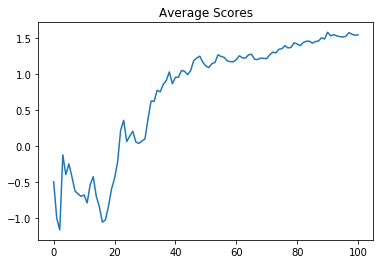

In [19]:
epochs_train = 101
prefix='fc_train'
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent, env, epochs_train, prefix=prefix)
name = sorted(list(filter(lambda x:  prefix in x and 'mp4' in x, os.listdir(prefix))))[-1]
HTML(display_videos(name,prefix))

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [14]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential()
        model.add(Conv2D(15,(3,3), input_shape=(5,5, self.n_state,), activation='relu'))
        model.add(Conv2D(8,(3,3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(15, activation='relu'))
        model.add(Dense(4, activation='linear'))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

Epoch 000/101 | Loss 0.0060 | Win/lose count 5.0/6.0 (-1.0)
Epoch 001/101 | Loss 0.0173 | Win/lose count 4.0/3.0 (1.0)
Epoch 002/101 | Loss 0.0088 | Win/lose count 3.0/7.0 (-4.0)
Epoch 003/101 | Loss 0.0072 | Win/lose count 7.5/5.0 (2.5)
Epoch 004/101 | Loss 0.0094 | Win/lose count 4.0/2.0 (2.0)
Epoch 005/101 | Loss 0.0008 | Win/lose count 6.0/1.0 (5.0)
Epoch 006/101 | Loss 0.0051 | Win/lose count 3.0/4.0 (-1.0)
Epoch 007/101 | Loss 0.0191 | Win/lose count 7.5/11.0 (-3.5)
Epoch 008/101 | Loss 0.0030 | Win/lose count 9.5/10.0 (-0.5)
Epoch 009/101 | Loss 0.0037 | Win/lose count 3.0/4.0 (-1.0)
Epoch 010/101 | Loss 0.0060 | Win/lose count 4.0/2.0 (2.0)
Epoch 011/101 | Loss 0.0074 | Win/lose count 4.0/7.0 (-3.0)
Epoch 012/101 | Loss 0.0080 | Win/lose count 6.5/7.0 (-0.5)
Epoch 013/101 | Loss 0.0205 | Win/lose count 6.0/1.0 (5.0)
Epoch 014/101 | Loss 0.0101 | Win/lose count 5.5/4.0 (1.5)
Epoch 015/101 | Loss 0.0067 | Win/lose count 6.0/9.0 (-3.0)
Epoch 016/101 | Loss 0.0007 | Win/lose count 

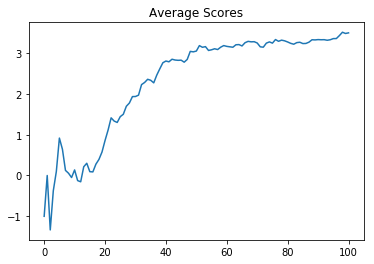

In [15]:
prefix = 'cnn_train'
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix=prefix)
name = sorted(list(filter(lambda x: prefix in x and '.mp4' in x, os.listdir(prefix))))[-1]
HTML(display_videos(name, prefix))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [25]:
env = Environment(grid_size=size, max_time=T,temperature=0.7)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')

epochs_test = 50
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 4.5/0.0. Average score (4.5)
Win/lose count 4.5/1.0. Average score (4.909090909090909)
Win/lose count 4.5/0.0. Average score (4.928571428571429)
Win/lose count 6.5/0.0. Average score (5.274193548387097)
Win/lose count 1.0/0.0. Average score (5.439024390243903)
Final score: 5.34
Test of the FC
Win/lose count 0/1.0. Average score (-1.0)
Win/lose count 0.5/0.0. Average score (0.5909090909090909)
Win/lose count 0.5/0.0. Average score (0.30952380952380953)
Win/lose count 1.0/0.0. Average score (0.3064516129032258)
Win/lose count 0.5/0.0. Average score (0.34146341463414637)
Final score: 0.28


**Answer**

When doing many experiments it seemed the DQN_CNN  performed better than its fully-connected counterpart. 

However both tend to get stuck in certain places, which is not good.
Augmenting the temperature to correct this issue.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [29]:
def train_explore(agent, env,epoch, epsilons=(0.1,0.01), prefix=''):
     # Number of won games
    score = 0
    loss = 0
    
    exp_start = epsilons[0]
    exp_end = epsilons[1]
    
    update_eps = lambda e: (exp_end - exp_start)/(epoch-1)*e + exp_start
    scores = []
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        
        epsilon = update_eps(e)
        agent.set_epsilon(epsilon)

        while not game_over:
            # The agent performs an action
            
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e), folder=prefix)

        # Update stats
        score += win-lose
        scores.append(score/(1+e))

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    
    plt.plot(scores)
    plt.title("Average Scores")
    plt.show()

In [30]:
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.5, visited_malus=0.15):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature
        self.visited_malus = visited_malus

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.visited_cells = np.zeros((grid_size, grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e,folder):
        if folder not in os.listdir():
            os.mkdir(folder)
        skvideo.io.vwrite(os.path.join(folder,str(e) + '.mp4'), self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action, train=True):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        if train:
            reward = self.board[self.x, self.y] - self.visited_cells[self.x, self.y]
            self.visited_cells[self.x, self.y] = self.visited_malus
        else:
            reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.visited_cells.reshape(self.grid_size, self.grid_size,1),
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.visited_cells.reshape(self.grid_size, self.grid_size,1),
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

Epoch 000/101 | Loss 0.0122 | Win/lose count 8.5/28.99999999999992 (-20.49999999999992)
Epoch 001/101 | Loss 0.0268 | Win/lose count 9.349999999999996/34.59999999999986 (-25.249999999999865)
Epoch 002/101 | Loss 0.0249 | Win/lose count 9.499999999999996/31.449999999999918 (-21.94999999999992)
Epoch 003/101 | Loss 0.0178 | Win/lose count 4.0/33.499999999999886 (-29.499999999999886)
Epoch 004/101 | Loss 0.0080 | Win/lose count 7.849999999999997/32.849999999999866 (-24.99999999999987)
Epoch 005/101 | Loss 0.0382 | Win/lose count 4.55/36.89999999999986 (-32.34999999999986)
Epoch 006/101 | Loss 0.0182 | Win/lose count 9.849999999999996/30.749999999999904 (-20.899999999999906)
Epoch 007/101 | Loss 0.0127 | Win/lose count 9.699999999999994/37.299999999999905 (-27.59999999999991)
Epoch 008/101 | Loss 0.0433 | Win/lose count 6.949999999999998/38.24999999999987 (-31.299999999999873)
Epoch 009/101 | Loss 0.0164 | Win/lose count 5.249999999999999/33.89999999999987 (-28.64999999999987)
Epoch 010/10

Epoch 082/101 | Loss 0.0188 | Win/lose count 3.8500000000000005/32.499999999999865 (-28.649999999999864)
Epoch 083/101 | Loss 0.0174 | Win/lose count 5.949999999999998/31.599999999999874 (-25.649999999999874)
Epoch 084/101 | Loss 0.0086 | Win/lose count 6.649999999999998/35.29999999999988 (-28.649999999999885)
Epoch 085/101 | Loss 0.0088 | Win/lose count 9.799999999999995/31.94999999999992 (-22.149999999999928)
Epoch 086/101 | Loss 0.0151 | Win/lose count 6.649999999999998/30.299999999999887 (-23.64999999999989)
Epoch 087/101 | Loss 0.0185 | Win/lose count 3.5000000000000004/33.64999999999989 (-30.149999999999892)
Epoch 088/101 | Loss 0.0390 | Win/lose count 8.399999999999997/31.549999999999905 (-23.149999999999906)
Epoch 089/101 | Loss 0.0311 | Win/lose count 8.749999999999996/35.39999999999988 (-26.64999999999988)
Epoch 090/101 | Loss 0.0110 | Win/lose count 5.949999999999998/38.59999999999985 (-32.64999999999986)
Epoch 091/101 | Loss 0.0272 | Win/lose count 5.249999999999999/33.8999

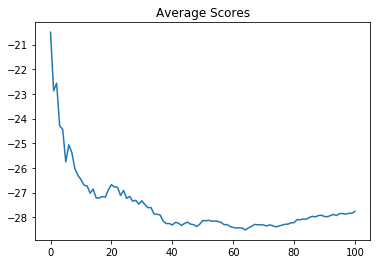

In [31]:
# Training
prefix='cnn_train_explore'
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')

name = sorted(list(filter(lambda x: prefix in x and '.mp4' in x, os.listdir(prefix))))[-1]
HTML(display_videos(name, prefix))

In [35]:
# Evaluation
test(agent,env,11,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4', 'cnn_test_explore/'))

Win/lose count 1.0499999999999998/30.699999999999886. Average score (-29.649999999999885)
Win/lose count 2.8000000000000003/30.949999999999886. Average score (-28.14999999999989)
Final score: -28.14999999999989


***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***